<a href="https://colab.research.google.com/github/Abinaya-hub2006/Computer_Vision/blob/main/Lucas_canade_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

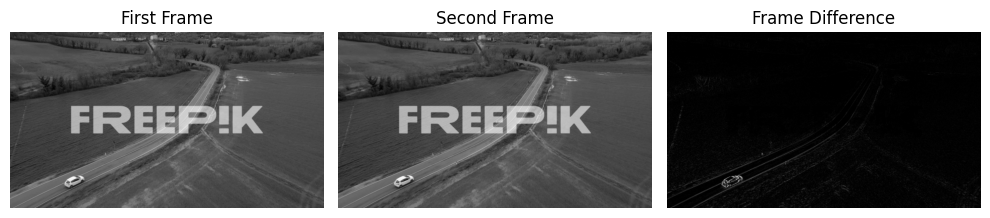

Processing frames: 100%|██████████| 222/222 [00:03<00:00, 58.01it/s]


Video saved to: /content/output.mp4


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Video
from tqdm import tqdm  # For progress bar

def lucas_kanade_optical_flow(video_path, output_path="/content/output.mp4"):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) // 2)
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) // 2)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, 20.0, (width, height))

    # Parameters for Shi-Tomasi corner detection
    feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

    # Parameters for Lucas-Kanade optical flow
    lk_params = dict(winSize=(15, 15), maxLevel=2,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # Random colors for visualizing flow
    color = np.random.randint(0, 255, (100, 3))

    # Read the first frame
    ret, old_frame = cap.read()
    if not ret:
        print("Error: Cannot read video.")
        return

    old_frame = cv2.resize(old_frame, (width, height))
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

    if p0 is None:
        print("No good features to track found.")
        return

    mask = np.zeros_like(old_frame)

    # Read the second frame for frame difference
    ret, frame = cap.read()
    if not ret:
        print("Error: Not enough frames.")
        return

    frame = cv2.resize(frame, (width, height))
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_diff = cv2.absdiff(old_gray, frame_gray)

    # Plot first frame, second frame, and difference
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(old_gray, cmap='gray')
    plt.title("First Frame")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(frame_gray, cmap='gray')
    plt.title("Second Frame")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(frame_diff, cmap='gray')
    plt.title("Frame Difference")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    # Go back to start and run full optical flow
    cap.set(cv2.CAP_PROP_POS_FRAMES, 1)

    for _ in tqdm(range(1, total_frames - 1), desc="Processing frames"):
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, (width, height))
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        if p1 is not None and st is not None:
            good_new = p1[st == 1]
            good_old = p0[st == 1]

            for i, (new, old) in enumerate(zip(good_new, good_old)):
                a, b = new.ravel()
                c, d = old.ravel()
                mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i % 100].tolist(), 2)
                frame = cv2.circle(frame, (int(a), int(b)), 5, color[i % 100].tolist(), -1)

            final_output = cv2.add(frame, mask)

            # Add frame number
            frame_count = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
            cv2.putText(final_output, f"Frame: {frame_count}", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

            out.write(final_output)
            old_gray = frame_gray.copy()
            p0 = good_new.reshape(-1, 1, 2)
        else:
            # If tracking fails, detect new points
            p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

    cap.release()
    out.release()
    print("Video saved to:", output_path)
    display(Video(output_path, embed=True))

# Call the function
lucas_kanade_optical_flow("/content/car.mp4")
